In [266]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns

In [64]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
wheat_ripeness_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\wheat_just_ripeness_obs.csv')
wheat_ripeness_obs = wheat_ripeness_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
wheat_ripeness_obs['observed time to yellow ripeness'] = pd.to_timedelta(wheat_ripeness_obs['observed time to yellow ripeness']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(wheat_ripeness_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to yellow ripeness'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [38]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
wheat_ripeness_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\wheat_just_harvest_obs.csv')
wheat_ripeness_obs = wheat_ripeness_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
wheat_ripeness_obs['observed time to harvest'] = pd.to_timedelta(wheat_ripeness_obs['observed time to harvest']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(wheat_ripeness_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to harvest'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [133]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
flowering_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\just_flowering_obs.csv')
flowering_obs = flowering_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
flowering_obs['observed time to beginning of flowering'] = pd.to_timedelta(flowering_obs['observed time to beginning of flowering']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(flowering_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to beginning of flowering'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [ ]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')

In [61]:
ds_LSP_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE2 = interpolate_columns(ds_LSP_DE2, 270, 'NDVI', resolution=8)
just_NDVI2 = ds_LSP_DE2.merge(flowering_obs, on = ['Stations_Id', 'year'])
just_NDVI2 = just_NDVI2.loc[just_NDVI2['observed time to beginning of flowering'] > 0]
just_NDVI2 = just_NDVI2.loc[just_NDVI2['NDVI interpolated at day 0'] > 0]

In [2]:
def get_station_locations_SSA(dataset, ds_stations):
    ds_stations.index = ds_stations['LocationID']#sitecode
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Latitude' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Longitude' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        elif predictor_type == 'MVI' or predictor_type == 'savgol_raw':
            date_columns = []
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

def offset_dates(row, offset_sample):
    row_NDVI = row.loc[[f'NDVI interpolated at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_NDVI.index = [f'NDVI interpolated at day {n}' for n in range(200)]
    row_temp = row.loc[[f't2m at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_temp.index = [f't2m at day {n}' for n in range(200)]
    row_phases = row.loc[['observed time to beginning of emergence', 'observed time to beginning of flowering', 'observed time to yellow ripeness']]
    row_phases = row_phases + np.timedelta64(60 - offset_sample[row.name], 'D')
    return pd.concat([row_NDVI, row_temp, row_phases], axis=0)

def interpolate_columns(ds, numdays, varname, resolution = 4):
    for day in range(numdays):
        upper = int((day // resolution)*resolution + resolution)
        lower = int((day // resolution)*resolution)
        coeff = (day % resolution)/resolution
        #print(lower, upper, coeff)
        #print(ds.loc[:, f'{varname} interpolated at day {upper}'].mean(), ds.loc[:, f'{varname} interpolated at day {lower}'].mean())
        ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*ds.loc[:, f'{varname} interpolated at day {lower}']
    return ds

def plot_ts_and_phen(ds, fig, ax, numdays = 274):
    for i in ds.index:
        series_at_index = ds.loc[i, :]
        Times = pd.to_datetime(series_at_index['Day of start']) + pd.to_timedelta(np.arange(0, numdays), 'D')
        Values = series_at_index[[f'NDVI interpolated at day {n}' for n in range(numdays)]]
        observation = pd.to_datetime(series_at_index['WC SOS date']) + pd.to_timedelta(series_at_index['observed time to beginning of flowering'], 'D')
        ax.plot(Times, Values)
        ax.axvline(observation)

def sample_augmented_frame(ds_inputs):
    series_length = 190
    offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs))*30) + 30
    #SOS_dates = ds_inputs['WC SOS date'] + pd.to_timedelta(offset_sample, 'D')#.shape
    ds_augmented = ds_inputs.loc[:, ['observed time to beginning of emergence',
                            'observed time to beginning of flowering',
                            'observed time to yellow ripeness',
                            'lat',
                            'lon',
                            'year',
                            'Stations_id',
                            'Day of start']]
    ds_augmented.loc[:, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))#np.array([0 for count in range(len(ds_inputs))])
    ds_augmented.loc[:, [f't2m at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))
    for row_number, row_index in enumerate(ds_inputs.index):
        print(row_number)
        augmented_start = offset_sample[row_number]
        ds_augmented.loc[row_index, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f'NDVI interpolated at day {n + augmented_start}' for n in range(series_length)]]
        ds_augmented.loc[row_index, [f't2m at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f't2m at day {n + augmented_start}' for n in range(series_length)]]
        #for n in range(series_length):
        #    
            #ds_augmented.loc[row_index, f'NDVI interpolated at day {n}'] = ds_inputs.loc[row_index, f'NDVI interpolated at day {n + augmented_start}']
            #ds_augmented.loc[row_index, f't2m at day {n}'] = ds_inputs.loc[row_index, f't2m at day {n + augmented_start}']
        for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
            ds_augmented.loc[row_index, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs.loc[row_index, f'observed time to {phase}']) + np.timedelta64(60 - augmented_start, 'D')
    return ds_augmented

In [3]:
ds_reanalysis_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data_Africa_t2m_PD_SOS.csv')
ds_reanalysis_SSA['Referenzjahr'] = pd.to_datetime(ds_reanalysis_SSA['WC SOS date']).dt.year
ds_reanalysis_SSA = ds_reanalysis_SSA.drop('Unnamed: 0', axis = 1).rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_SSA['year'] = ds_reanalysis_SSA['year'].astype(int)
ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_PD_SOS.csv')
#ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
#ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_SSA.csv')
ds_LSP_SSA = ds_LSP_SSA.drop(['Unnamed: 0'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['WC SOS date'] = pd.to_datetime(ds_inputs_SSA['WC SOS date'])
date_columns = ['mingrad', 'maxgrad', 
                'minday', 'maxday', 
                'first 50 percentile', 'last 50 percentile', 
                'first 90 percentile', 'last 90 percentile', 
                'observed time to beginning of flowering']
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
with warnings.catch_warnings(action="ignore"):
    ds_inputs_SSA = interpolate_columns(ds_inputs_SSA, 270, 'NDVI', resolution=8)
ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]], 7, 28, 42)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 'temperature', numdays = 300, T_base = 0)
stations_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon.csv')
ds_inputs_SSA = get_station_locations_SSA(ds_inputs_SSA, stations_data_lobell)
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Stations_Id':'Stations_id'})
ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI interpolated at day 0'] >= 0)*(ds_inputs_SSA['NDVI interpolated at day 32'] >= 0)]
#ds_inputs_SSA = ds_inputs_SSA.loc[(ds_inputs_SSA['NDVI at GDD 0'] >= 0)*(ds_inputs_SSA['NDVI at GDD 200'] >= 0)]
#ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']) - (pd.to_datetime(ds_inputs_SSA['Day of start']) - pd.to_datetime(ds_inputs_SSA['WC SOS date']))
#for column in date_columns:
#    ds_inputs_SSA[column] = pd.to_datetime(ds_inputs_SSA[column])
#    ds_inputs_SSA[column] = ds_inputs_SSA[column] - ds_inputs_SSA['WC SOS date']
#    ds_inputs_SSA[column] = ds_inputs_SSA[column].dt.days 
                

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25692\2104312202.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lat'] = lat
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25692\2104312202.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lon'] = lon


In [146]:
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_t2m_just_flowering.csv') #_60D_Offset
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')#_60_offset
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')
#ds_LSP_DE = ds_LSP_DE.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_sentinel.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')

In [268]:
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_t2m_just_flowering.csv') #_60D_Offset
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')#_60_offset
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')
#ds_LSP_DE = ds_LSP_DE.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_sentinel.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
with warnings.catch_warnings(action="ignore"):
    ds_inputs_DE = interpolate_columns(ds_inputs_DE, 270, 'NDVI', resolution=8)
ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 200, T_base = 0)
for phase in ['beginning of flowering']:#['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
    ds_inputs_DE.loc[:, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs_DE.loc[:, f'observed time to {phase}']).dt.days
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 0]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['NDVI interpolated at day 0'] >= 0]
#ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['NDVI at GDD 0'] >= 0]
#offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs_DE))*30) + 30
#resamples = ds_inputs_DE.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25692\2104312202.py:98: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [271]:
def get_categories(anthesis_date):
    return np.array([anthesis_date < n for n in range(183)]).squeeze().astype(np.int64)
cats = ds_inputs_DE[['observed time to beginning of flowering']].apply(get_categories, args = (), axis = 1)
cats_unlisted = cats.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
cats_unlisted = cats_unlisted.rename(columns = {n: f'dev stage at day {n}' for n in range(183)})
ds_inputs_DE = ds_inputs_DE.merge(cats_unlisted, left_index=True, right_index = True)

In [272]:
skip = 1
numsteps = int(183 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {skip*n}' for n in range(numsteps)]].values)
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, NDVI_series_DE)), 0, 1)
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [209]:
NDVI_labels_DE.view()

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [6]:
skip = 1
numsteps = int(183 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)

In [112]:
skip = 4
numsteps = int(183 // skip) #int(203 // skip)
NDVI_series_DE = torch.Tensor(just_NDVI[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
#NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to beginning of flowering'].astype('int64').values)
NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to beginning of flowering'].astype('int64').values)

In [39]:
NDVI_series_DE.shape

torch.Size([10019, 45])

In [89]:
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2400, 100)]].values)
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering GDD'].values)

In [55]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2200, 100)]].values)
NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering GDD'].values)

In [11]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(195)]].values)
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n}' for n in range(195)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].values)

In [8]:
class Skeleton(nn.Module):
    model_info = {}

    def count_params(self):
        num_params = 0
        for param in self.parameters():
            num_params += np.prod(param.data.shape)
        print(f"Number of trainable parameters: {num_params:,}")
        return num_params

    def print_model_info(self):
        assert "model_info" in self.__dict__.keys()
        for k, v in self.model_info.items():
            print(f"{k.upper()}: {v}")
        print()

    def update_attributes(self, locals):  # put locals() to record configurations
        try:
            del locals["self"]  # Cannot be pickled
            del locals["__class__"]
        except KeyError:
            pass
        self.__dict__.update(locals)
        self.model_info.update(locals)
        self.model_info = {key: value for key, value in sorted(self.model_info.items())}

    def update_init_args(self, locals):
        try:
            del locals["self"]  # Cannot be pickled
        except KeyError:
            pass
        try:
            del locals["__class__"]  # Cannot be pickled
        except KeyError:
            pass
        self.model_init_args = {}
        self.model_init_args.update(locals)

    def set_device(self):
        if platform.system() == "Darwin" and torch.backends.mps.is_available():
            self.device = "mps"
        elif torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import platform
from copy import deepcopy
import random
import time
import os, sys
from typing import List, Tuple
from torch import Tensor
import warnings
import math

sys.path.append(os.getcwd())
#from architectures.skeleton import Skeleton


In [10]:
class ResidualConvolution(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size: int = 3,
        stride: int = 1,
        dropout: float = 0,
        activation: str = "gelu",
        pool: str = "max",
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.activation = {
            "gelu": nn.GELU(),
            "relu": nn.ReLU(),
            "elu": nn.ELU(),
            "selu": nn.SELU(),
        }[activation]
        self.pool = {
            "max": nn.MaxPool1d(kernel_size, stride),
            "avg": nn.AvgPool1d(kernel_size, stride),
        }[pool]
        self.dropout = nn.Dropout(dropout)

        # convolution layers
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # downsample layers
        self.downsample = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)

        residual = self.downsample(x)
        residual = self.dropout(residual)

        out = out + residual
        out = self.bn2(out)
        out = self.activation(out)

        out = self.pool(out)
        return out


class StackedResidualConvolution1D(Skeleton):
    def __init__(
        self,
        in_channels,
        n_stacks=1,
        kernel_size: int = 3,
        stride: int = 1,
        dropout: float = 0,
        cnn_activation="gelu",
    ):
        super().__init__()
        self.model_info = {}  # initialize self.model_info to use update_attributes()
        self.update_attributes(locals())
        self.update_init_args(locals())

        # CNNs
        base = 1.3
        self.stacks = nn.ModuleList()
        for i in range(n_stacks):
            if i == 0:
                self.stacks.append(
                    ResidualConvolution(
                        round(in_channels * base**i),
                        round(in_channels * base ** (i + 1)),
                        kernel_size=kernel_size,
                        stride=stride,
                        dropout=dropout,
                        activation=cnn_activation,
                        pool="max",
                    )
                )
            else:
                self.stacks.append(
                    ResidualConvolution(
                        round(in_channels * base**i),
                        round(in_channels * base ** (i + 1)),
                        kernel_size=kernel_size,
                        stride=stride,
                        dropout=dropout,
                        activation=cnn_activation,
                        pool="avg",
                    )
                )
        self.output_size = round(in_channels * base**n_stacks)

    def forward(self, x: torch.Tensor):
        output = x  # (N,C,L)
        for cnn in self.stacks:
            output = cnn.forward(output)  # (N,Cout,Lout)
        output = output.permute(0, 2, 1)  # (N,Lout,Cout)
        return output


In [12]:
B = 32
Cin = 27
L = 20
x = torch.randn(B, Cin, L)
net = StackedResidualConvolution1D(in_channels=Cin, n_stacks=4)
out = net(x)

In [15]:
x.shape

torch.Size([32, 27, 20])

In [14]:
out.shape

torch.Size([32, 4, 77])

In [16]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_size = 2
hidden_size = 3
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

In [22]:
X.unsqueeze(2).shape

torch.Size([1434, 2, 1, 183])

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [120]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Forward pass through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0)) # output: (batch, seq_len, hidden_dim)
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(output) # (batch, output_dim)
        out_scores = F.log_softmax(out_space, dim=2)

        return out_scores


In [135]:
import copy
LC = LSTMClassifier(2, 3, 2, 2)
X = temp_NDVI_series_DE
X = torch.transpose(X[:1, :, :], 1, 2)
A = LC.forward(X)
X1 = copy.deepcopy(X)
X1[:, 5:, :] = 0
B = LC.forward(X1)
#print(A - B)
#print(B)
#print(X - X1)
loss_function = nn.NLLLoss()
loss_function(A.transpose(1, 2), y.long())

tensor(0.9639, grad_fn=<NllLoss2DBackward0>)

In [42]:
y = torch.Tensor([0 for count in range(X.shape[1])]).unsqueeze(0)

In [54]:
torch.Tensor(np.int64(model(X) > 0.5)).squeeze(2)#.shape

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [53]:
crit = nn.CrossEntropyLoss()
crit(torch.Tensor(np.int64(model(X) > 0.5)).squeeze(2), y)

tensor(-0.)

0 0.6898691596261727 0.6577358743636456
5 0.101850595786366 0.09860041611255792
10 0.0947109256144939 0.0921849399272057
15 0.09160398076241927 0.08936003066827251
20 0.09033979893174947 0.0881498704160848
25 0.08973143881818187 0.0875496050896207
30 0.0893777849868529 0.08720089176147326
35 0.0891378511585976 0.0869672463433368
40 0.08894800676765646 0.08678547543231659
45 0.08876305975488309 0.08660928742402943


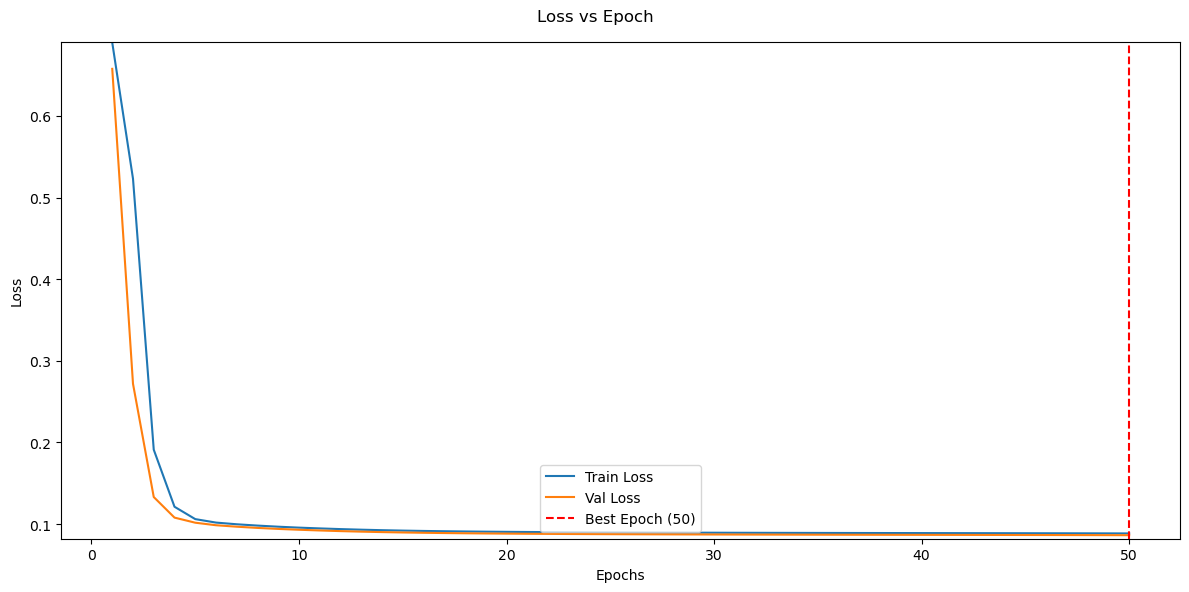

In [274]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 3
num_layers = 2
output_dim = 2  # Example: 5 classes

model = LSTMClassifier(input_dim, hidden_dim, num_layers, output_dim)

# Loss function and optimizer
criterion = nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = 'LSTM1')

In [251]:
183 - plot_from_saved('LSTM1', model, val_dl).sum(dim=1)#.shape

tensor([ 92.,  74.,  98., 128.,  91.,  97., 102.,  93., 102.,  89.,  91.,  94.,
         98., 100., 103., 100., 104.,  81.,  99.,  78.,  80., 106.,  89., 103.,
        104., 105.,  87., 107.,  94.,  79.,  84.,  98., 110., 112.,  99.,  82.,
         81.,  73., 100.,  92.,  83.,  82.,  83.,  91.,  87., 102.,  98., 102.,
        104.,  98., 106.,  94.,  89.,  91., 114.,  91.,  93.,  96.,  79., 115.,
         82.,  91., 107.,  95.,  85., 105., 105., 101.,  79., 100.,  87.,  88.,
         80.,  86., 108.,  90., 101.,  79.,  81., 107.,  88., 106., 101.,  89.,
         91.,  98.,  94.,  92.,  94.,  92.,  97.,  94., 104., 103.,  94.,  96.,
        105., 107.,  82.,  80., 101.,  87., 102.,  96.,  95.,  82.,  89.,  84.,
        114.,  91.,  99., 106., 102., 102., 117.,  95.,  96.,  95., 102., 101.,
        101.,  95., 109.,  95., 101.,  88.,  99.,  96.,  93.,  85., 104., 132.,
         75.,  84., 105.,  96., 105., 111.,  94.,  88., 110., 101.,  94., 103.,
        112.,  86., 102., 123., 111., 11

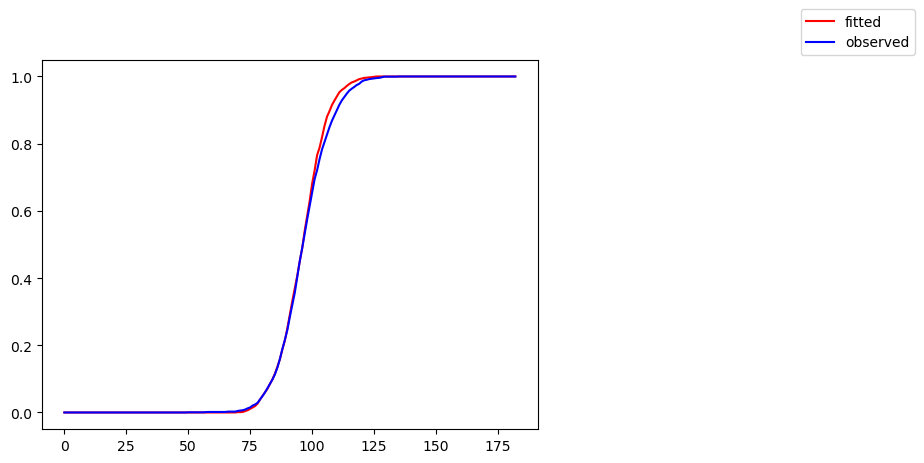

In [276]:
plot_from_saved('LSTM1', model, val_dl, method = 'proportions')

R^2 value for model: 0.2714660167694092
Bias: 0.4955992038383617
Variance of modelled values: 83.08891961306911


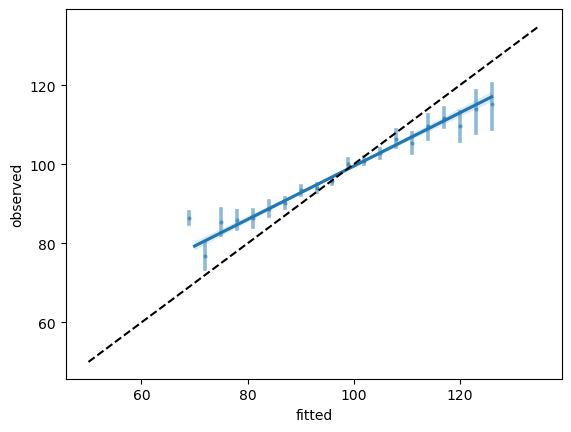

In [277]:
plot_from_saved('LSTM1', model, val_dl, method = 'regression')

In [265]:
def plot_from_saved(savename, model, val_dl, method = 'regression'):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if method == 'proportions':
        plot_fitted_observed_proportions(model, val_dl)
    elif method == 'regression':
        plot_fitted_observed_TS(model, val_dl)

In [263]:
def plot_fitted_observed_proportions(TS_model, dl):
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.cat(list_logs)
    fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_proportions = fitted.to(torch.float).mean(dim=0)
    observed = torch.cat(list_observed)
    observed_proportions = observed.to(torch.float).mean(dim=0)
    fig, ax = plt.subplots()
    ax.plot(fitted_proportions, color = 'red', label = 'fitted')
    ax.plot(observed_proportions, color = 'blue', label = 'observed')
    fig.legend(bbox_to_anchor = (1.5, 1))

In [252]:
def plot_fitted_observed_TS(TS_model, dl):
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.cat(list_logs)
    fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.regplot(x='fitted', y='observed', data = comparison_frame, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [220]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.transpose(1, 2))
    loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def plot_train_val_loss(num_epochs, train_losses, val_losses, best_epoch):

    epochs = range(1, num_epochs + 1)
    # Plot Losses
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses, label='Val Loss')
    ax.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
    fig.suptitle('Loss vs Epoch')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ymax = min((np.array(val_losses)[:20].max())*1.05, 40)
    ymin = (np.array(val_losses).min())*0.95
    ax.set_ylim([ymin, ymax])
    plt.legend()

    # Show the plots
    plt.tight_layout()

def dl_variance(dl):
    running_var = 0
    running_len = 0
    for xb, yb in dl:
        running_var += torch.var(yb)*(len(yb) - 1)
        running_len += len(yb)
    return running_var/(running_len - 1)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, save_name = 'best_model'):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 1
    best_epoch = 0

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()
        running_var = 0
        running_var_val = 0

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt)
            running_loss += batch_loss*batch_len
            running_samples += batch_len

        train_loss = running_loss/running_samples
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch + 1
            best_model_state = deepcopy(model.state_dict())

        #Save the model at the last epoch
        if epoch == epochs - 1:
            #torch.save(model.state_dict(), 'saved_models/last_test.pth')
            model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
            model_path = os.path.join(model_dir, save_name + ".pt")
            #torch.save(model.state_dict(), model_path)
            torch.save({'epoch': best_epoch, 'model_state_dict': best_model_state}, model_path)
        if epoch % 5 == 0:
            #train_r2 = 1 - ((train_loss**2)/train_var)
            #val_r2 = 1 - ((val_loss**2)/val_var)
            print(epoch, train_loss, val_loss)
            #print(f'R2 on train set: {train_r2}\nR2 on test set: {val_r2}')
    plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

def preprocess(x, y, channels = 1):
    if channels == 1:
        return x[:, None, :], y#.view(-1, 1)
    else:
        return x, y#.view(-1, 1)

def train_test_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

def plot_fitted_observed(TS_model, dl):
    list_fitted = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            list_fitted.append(TS_model(xb))
        list_observed.append(yb)
    fitted = torch.cat(list_fitted)
    observed = torch.cat(list_observed)
    comparison_frame = pd.DataFrame({'fitted': fitted.numpy().squeeze(), 'observed': observed.numpy().squeeze()})
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.regplot(x='fitted', y='observed', data = comparison_frame, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [99]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [57]:
bs = 2000
n_channels = 1
skip = 4
numsteps = int(199 // skip)
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {n*skip}' for n in range(numsteps)]].values)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [89]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

0 96.84303283691406 96.87023162841797
R2 on train set: -76.62422180175781
R2 on test set: -71.15215301513672
5 96.77468872070312 96.75077056884766
R2 on train set: -76.51470184326172
R2 on test set: -70.97431182861328
10 96.3301773071289 96.221923828125
R2 on train set: -75.80424499511719
R2 on test set: -70.18962097167969
15 95.32610321044922 95.02777862548828
R2 on train set: -74.21148681640625
R2 on test set: -68.4336166381836
20 90.5361328125 85.08609771728516
R2 on train set: -66.8428955078125
R2 on test set: -54.66546630859375
25 72.37852478027344 40.58394241333008
R2 on train set: -42.35906982421875
R2 on test set: -11.664180755615234
30 96.97423553466797 91.8770523071289
R2 on train set: -76.8346939086914
R2 on test set: -63.90568542480469
35 106.55482482910156 114.25272369384766
R2 on train set: -92.97378540039062
R2 on test set: -99.36949920654297
40 142.76829528808594 145.8023681640625
R2 on train set: -167.7034912109375
R2 on test set: -162.454833984375
45 97.28972625732422

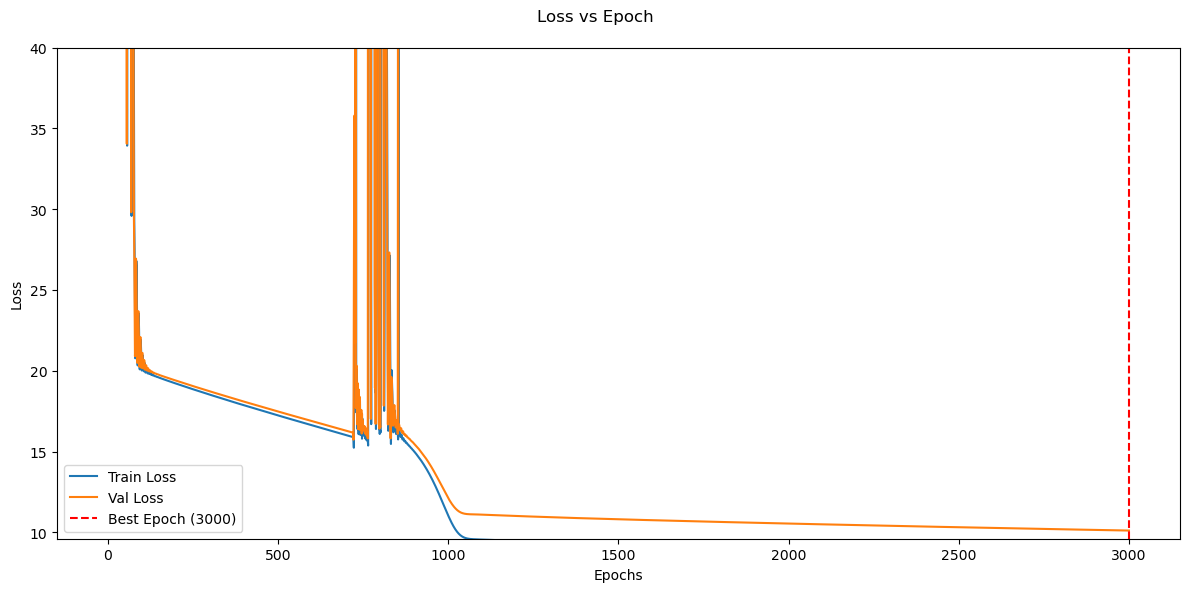

In [13]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

lr = 0.03
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 3000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_and_NDVI2')

R^2 value for model: -3.1147475242614746
Bias: 141.29671261938347
Variance of modelled values: 126.1581802368164


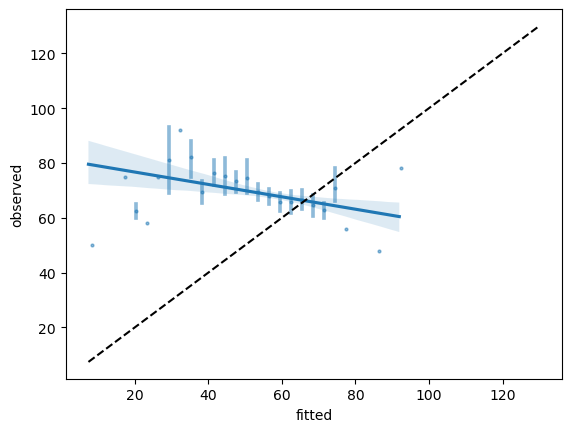

In [12]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('Temp_and_NDVI2', model, val_dl_SSA)

R^2 value for model: 0.10036206245422363
Bias: 1.8609495842829347
Variance of modelled values: 10.677059173583984


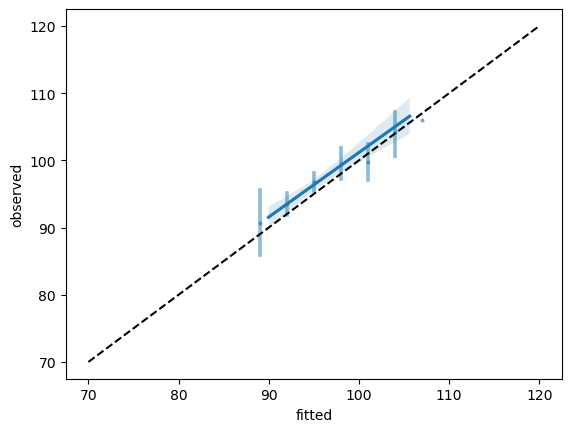

In [48]:
#train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model2 = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),#nn.Linear(numsteps, 1)#
    Lambda(lambda x: x.view(x.size(0), -1)),
) 

model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, 'NDVI_CNN' + ".pt")

checkpoint = torch.load(model_path, weights_only=True)
model2.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plot_fitted_observed(model2, val_dl)

In [11]:
def plot_from_saved(savename, model, val_dl):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    plot_fitted_observed(model, val_dl)

In [81]:
torchinfo.summary(model)#.eval()

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv1d: 1-1                            11
├─LeakyReLU: 1-2                         --
├─Conv1d: 1-3                            4
├─LeakyReLU: 1-4                         --
├─AdaptiveAvgPool1d: 1-5                 --
├─Lambda: 1-6                            --
Total params: 15
Trainable params: 15
Non-trainable params: 0

In [82]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")

Parameter name: 0.weight
Parameter value: Parameter containing:
tensor([[[  7.1422,  -2.4835,  -2.7349,   1.2524,  -4.4099],
         [  5.1709,  -0.2092, -10.8349,  -1.1365,  -3.4423]]],
       requires_grad=True)
Parameter name: 0.bias
Parameter value: Parameter containing:
tensor([-40.6502], requires_grad=True)
Parameter name: 2.weight
Parameter value: Parameter containing:
tensor([[[-2.5403, -1.5112, -0.5888]]], requires_grad=True)
Parameter name: 2.bias
Parameter value: Parameter containing:
tensor([111.1209], requires_grad=True)


In [44]:
C1 = list(model.children())[0]
RU1 = list(model.children())[1]
C2 = list(model.children())[2]
RU2 = list(model.children())[3]
AP = list(model.children())[4]

In [92]:
def plot_all_channels(X, fig, ax):
    for channel_index in range(X.shape[0]):
        ax.plot(X[channel_index, :])

In [93]:
def plot_each_layer(TS_model, X):
    layers = list(TS_model.children())
    fig, axs = plt.subplots(len(layers) + 1, 1, figsize = (3, 10))
    plot_all_channels(X, fig, axs[0])
    X_at_layer = X
    for layer_index, layer in enumerate(layers):
        ax = axs[layer_index + 1]
        with torch.no_grad():
            X_at_layer = layer(X_at_layer)
        plot_all_channels(X_at_layer, fig, ax)


In [51]:
X = temp_NDVI_series_DE[0, :, :]
X.shape

torch.Size([2, 45])

In [158]:
NDVI_series_DE.shape

torch.Size([1720, 45])

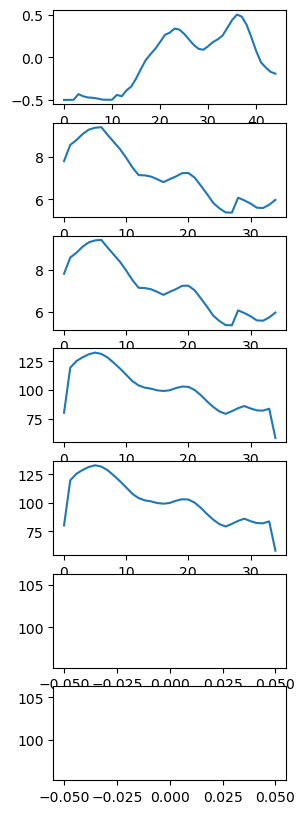

In [138]:
plot_each_layer(model, NDVI_series_DE.view(-1, 1, 45)[14, :, :] - 0.5)

In [72]:
with torch.no_grad():
    print(AP(RU2(C2(RU1(C1(temp_NDVI_series_DE[0, :, :]))))))

tensor([[91.1205]])


0 96.38427734375 93.2884521484375
R2 on train set: -92.55133819580078
R2 on test set: -81.62979888916016
5 62.67894744873047 107.28910827636719
R2 on train set: -38.562252044677734
R2 on test set: -108.29296875
10 32.44706344604492 43.75981521606445
R2 on train set: -9.602014541625977
R2 on test set: -17.181591033935547
15 20.98536491394043 32.64659881591797
R2 on train set: -3.434765338897705
R2 on test set: -9.119447708129883
20 24.758493423461914 28.597997665405273
R2 on train set: -5.172854423522949
R2 on test set: -6.765191555023193
25 24.469512939453125 25.29242515563965
R2 on train set: -5.02959680557251
R2 on test set: -5.073819637298584
30 19.683284759521484 26.15377426147461
R2 on train set: -2.90151047706604
R2 on test set: -5.494558811187744
35 19.547494888305664 21.08934211730957
R2 on train set: -2.847865104675293
R2 on test set: -3.222862720489502
40 18.2839298248291 20.21169090270996
R2 on train set: -2.366485118865967
R2 on test set: -2.8787002563476562
45 17.562793731

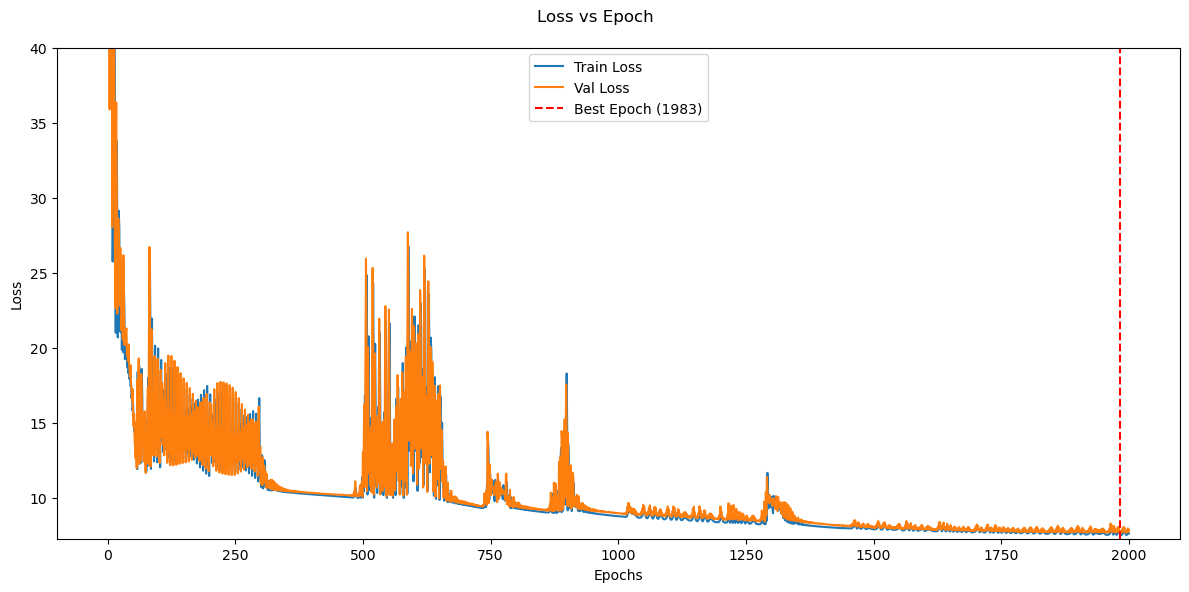

In [124]:
bs = 2000
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=2, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 2, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(14, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.05
#model = phen_CNN_1d()
#opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 2000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_CNN3')

R^2 value for model: -0.34430789947509766
Bias: 49.77136073321162
Variance of modelled values: 113.59953308105469


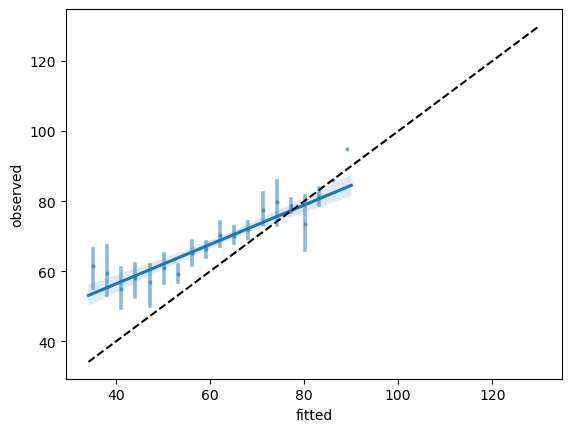

In [77]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('Temp_CNN2', model, val_dl_SSA)

In [ ]:
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=7),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    #nn.Conv1d(3, 3, kernel_size=3, padding=1),
    #nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

R^2 value for model: 0.3563251495361328
Bias: 0.4535612259642221
Variance of modelled values: 35.384422302246094


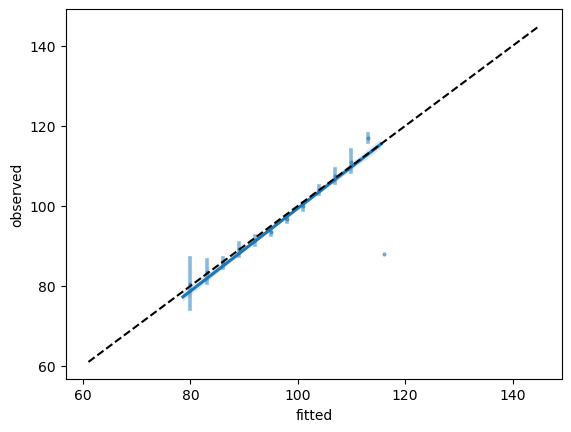

In [92]:
plot_from_saved('Temp_NDVI_CNN', model, val_dl)

In [82]:
temp_series_DE.shape

torch.Size([9838, 183])

In [119]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='Temp_NDVI_CNN')

AssertionError: Size mismatch between tensors

0 69.37451171875 67.8327865600586
R2 on train set: -42.9195442199707
R2 on test set: -53.61483383178711
5 59.34967803955079 46.80571365356445
R2 on train set: -31.143611907958984
R2 on test set: -25.003334045410156
10 17.933143615722656 10.845736503601074
R2 on train set: -1.9347476959228516
R2 on test set: -0.3962055444717407
15 11.519375801086426 15.851170539855959
R2 on train set: -0.210921049118042
R2 on test set: -1.9823181629180908
20 14.561492919921875 12.990528106689453
R2 on train set: -0.9349501132965088
R2 on test set: -1.0030181407928467
25 13.514237403869627 11.005656242370605
R2 on train set: -0.6666370630264282
R2 on test set: -0.43768310546875
30 11.399699211120605 11.144886016845703
R2 on train set: -0.18589091300964355
R2 on test set: -0.4742887020111084
35 11.845677375793457 10.230749130249023
R2 on train set: -0.2804945707321167
R2 on test set: -0.2423563003540039
40 11.311026573181152 9.818648338317871
R2 on train set: -0.16751372814178467
R2 on test set: -0.144286

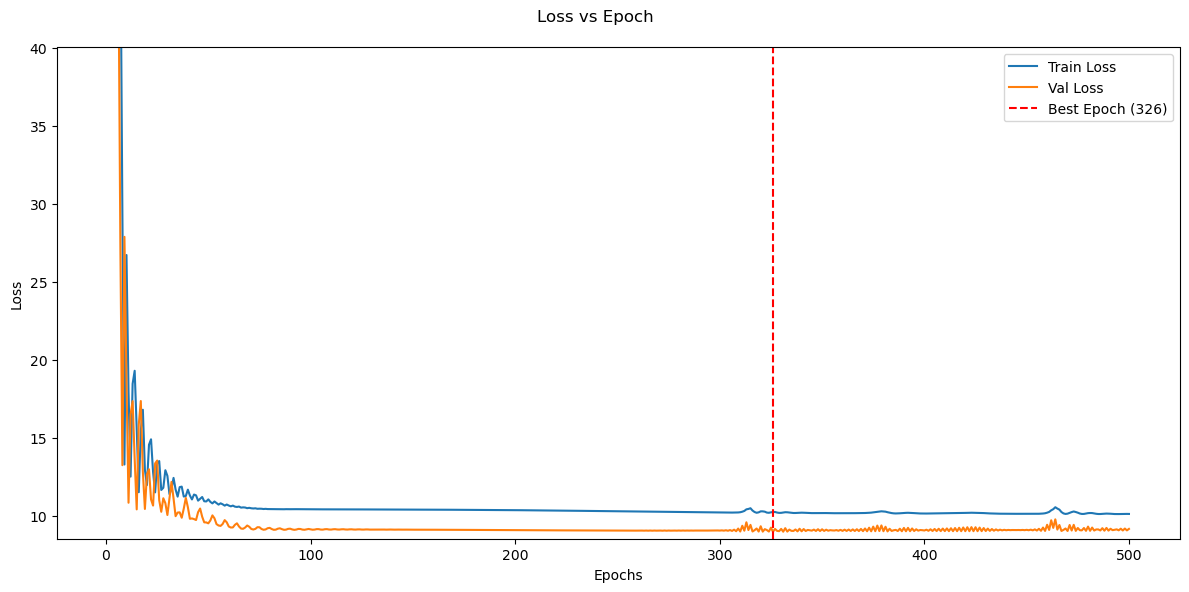

In [15]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='NDVI_CNN')

R^2 value for model: -5.707334995269775
Bias: 585.5852026978973
Variance of modelled values: 23.180936813354492


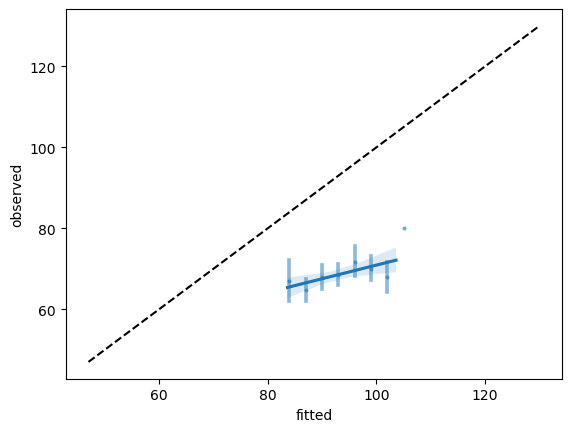

In [116]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('GDD_NDVI_CNN', model, val_dl_SSA)

In [105]:
ds_inputs_DE

,Unnamed: 0,year,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,...,NDVI interpolated at day 260,NDVI interpolated at day 261,NDVI interpolated at day 262,NDVI interpolated at day 263,NDVI interpolated at day 265,NDVI interpolated at day 266,NDVI interpolated at day 267,NDVI interpolated at day 268,NDVI interpolated at day 269,maxday
19,188.0,2018,7521.0,2018-02-18,0.320304,0.323722,0.330771,0.341449,0.371024,0.384390,...,0.591544,0.596834,0.602124,0.607414,0.619792,0.626881,0.633970,0.641058,0.648147,136
20,151.0,2019,7521.0,2019-02-18,0.524035,0.506643,0.500193,0.504684,0.521082,0.544190,...,0.604712,0.602203,0.599695,0.597187,0.592372,0.590066,0.587760,0.585454,0.583148,168
21,114.0,2020,7521.0,2020-02-18,0.530496,0.506531,0.491904,0.486614,0.512788,0.517554,...,0.581658,0.584183,0.586709,0.589234,0.597541,0.603322,0.609103,0.614885,0.620666,208
22,75.0,2021,7521.0,2021-02-18,0.425831,0.444292,0.464603,0.486765,0.498273,0.530083,...,0.535018,0.533659,0.532301,0.530942,0.531344,0.533104,0.534865,0.536625,0.538385,152
23,37.0,2022,7521.0,2022-02-18,0.255260,0.354114,0.432829,0.491404,0.507362,0.530332,...,0.586019,0.582100,0.578180,0.574261,0.564436,0.558530,0.552624,0.546718,0.540812,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,62.0,2021,19585.0,2021-02-18,0.461548,0.498599,0.525763,0.543039,0.542019,0.552136,...,0.568327,0.564398,0.560470,0.556541,0.548578,0.544544,0.540509,0.536475,0.532441,152
21418,26.0,2022,19585.0,2022-02-18,0.496610,0.527470,0.549909,0.563928,0.549505,0.561102,...,0.565575,0.572492,0.579409,0.586327,0.602216,0.611187,0.620159,0.629131,0.638102,144
21436,212.0,2017,19587.0,2017-02-18,0.425085,0.427672,0.446832,0.482566,0.549552,0.620637,...,0.602370,0.601895,0.601420,0.600946,0.601043,0.601616,0.602189,0.602761,0.603334,96
21503,174.0,2018,19700.0,2018-02-18,0.105831,0.221034,0.303757,0.354002,0.346518,0.285715,...,0.534139,0.539760,0.545381,0.551002,0.564852,0.573080,0.581309,0.589537,0.597766,144


In [33]:
NDVI_series_DE.shape

torch.Size([2380, 65])

0 98.18644301962925 96.3691635131836
R2 on train set: -80.85773468017578
R2 on test set: -77.05242919921875
5 41.90771146395453 15.667854309082031
R2 on train set: -13.912298202514648
R2 on test set: -1.0631427764892578
10 22.35223292423864 14.289529800415039
R2 on train set: -3.24227237701416
R2 on test set: -0.7161139249801636
15 14.279389490593287 11.121830940246582
R2 on train set: -0.7313146591186523
R2 on test set: -0.03959167003631592
20 10.480188671262205 12.281865119934082
R2 on train set: 0.06740105152130127
R2 on test set: -0.2677654027938843
25 10.795738721815766 10.856291770935059
R2 on train set: 0.010396003723144531
R2 on test set: 0.009457170963287354
30 10.290813680222124 10.92855167388916
R2 on train set: 0.10080033540725708
R2 on test set: -0.0037728548049926758
35 10.127608115329272 10.82460880279541
R2 on train set: 0.12909561395645142
R2 on test set: 0.015230357646942139
40 10.032753157642974 10.760037422180176
R2 on train set: 0.145332932472229
R2 on test set: 0.

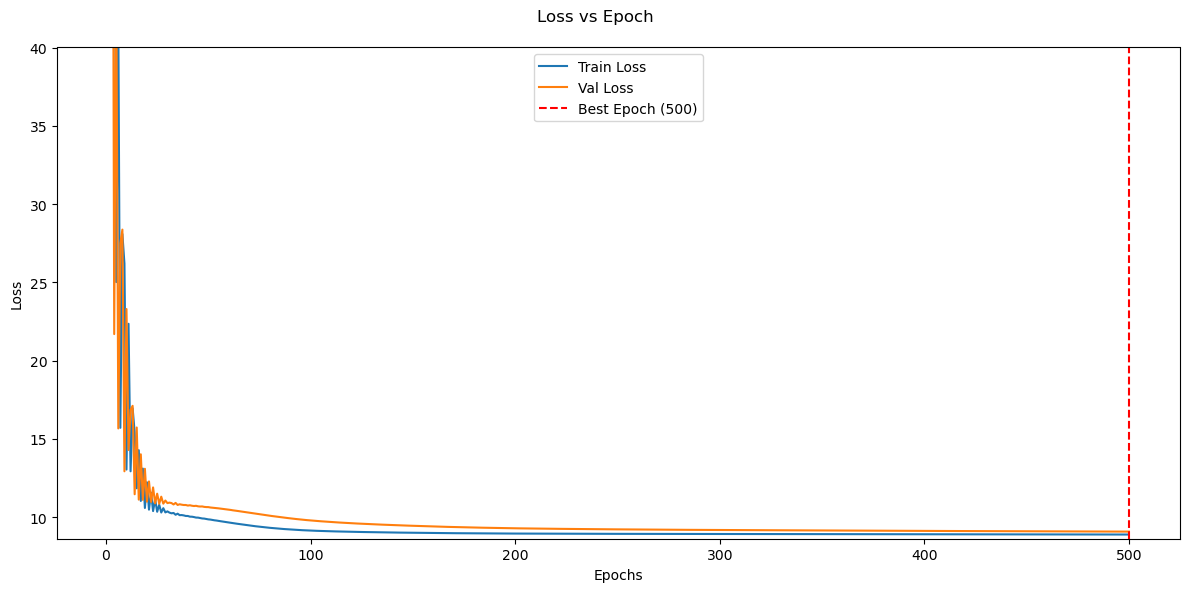

In [16]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(9, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='GDD_NDVI_CNN')

In [170]:
val_dl.dl.dataset.dataset

In [175]:
for xb, yb in val_dl:
    with torch.no_grad():
        print(torch.cat((model(xb), model(xb))).shape)

torch.Size([688, 1])


In [184]:
observed.numpy().squeeze().shape

(344,)

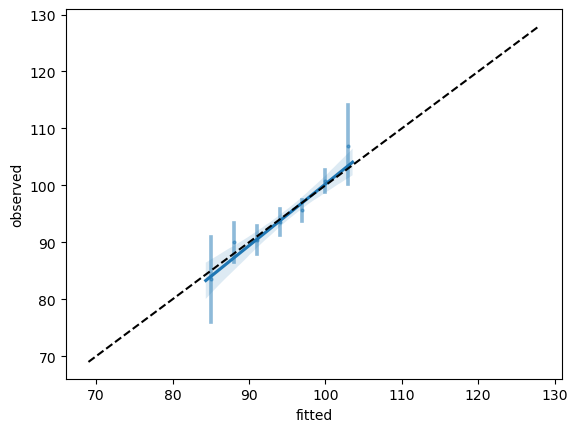

In [193]:
plot_fitted_observed(model, val_dl)


In [49]:
model, opt = get_model()
print(loss_func(model(xb), yb))

In [ ]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n*4}' for n in range(25)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n*4}' for n in range(25)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)

In [58]:
in_channels = 2
out_channels = 4
Kernel_size = 4
c = torch.nn.Conv1d(in_channels, out_channels, Kernel_size)

In [61]:
temp_NDVI_series.shape

torch.Size([240, 2, 25])

In [60]:
c(temp_NDVI_series).shape

torch.Size([240, 4, 22])

In [33]:
ds_inputs_DE.dropna(how='any')[['Day of start', 'WC SOS date']]

# Note to self: start NDVI a bit along

,Day of start,WC SOS date
19,2018-04-03,2018-04-15
20,2019-04-03,2019-04-15
21,2020-04-02,2020-04-14
22,2021-04-03,2021-04-15
23,2022-04-03,2022-04-15
...,...,...
21500,2021-04-03,2021-04-15
21501,2022-04-03,2022-04-15
21519,2017-04-03,2017-04-17
21586,2018-04-03,2018-04-18


In [75]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]


#dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [76]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train, test = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(train, batch_size=len(train), train=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(test, batch_size=len(test), train=False, transform=transform)
trainset = PandasDataset(train)
testset = PandasDataset(test)
 
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 20, kernel_size=4, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(128, 16)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(64, 16)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CNN1d()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 10
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>